In [19]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from skgarden import RandomForestQuantileRegressor
import pandas as pd
from sklearn.metrics import r2_score

In [4]:

#dataframe final
df_final = pd.read_csv("../data/DF_train15_skempiAB_modeller_final.csv",index_col=0)

#index_ddg8 = (df_final['ddG_exp']>)
#df_final = df_final.loc[-index_ddg8]

#testiar eliminando estructuras con ddg menor o igual a -4 kcal/mol , outliers
#index_ddg_4 =  (df_final['ddG_exp'] <= -4)
#df_final = df_final.loc[-index_ddg_4]


pdb_names = df_final.index
features_names = df_final.drop('ddG_exp',axis=1).columns

In [5]:
X = df_final.drop('ddG_exp',axis=1).astype(float)
y = df_final['ddG_exp']

In [21]:
RandomForestQuantileRegressor?

In [6]:
kf = KFold(n_splits=10, random_state=0)
rfqr = RandomForestQuantileRegressor(random_state=0, min_samples_split=10, n_estimators=100,max_features="log2")

In [27]:
y_test

3NPS.protein.A214A.Repair4.clean.pdb    0.635009
3NPS.protein.A218A.Repair4.clean.pdb   -0.017714
3NPS.protein.A219A.Repair4.clean.pdb   -0.036324
3NPS.protein.A221A.Repair4.clean.pdb   -0.044857
3NPS.protein.A23A.Repair4.clean.pdb     0.011397
3NPS.protein.A26A.Repair4.clean.pdb     0.277748
3NPS.protein.A45A.Repair4.clean.pdb    -0.143657
3NPS.protein.A46A.Repair4.clean.pdb     0.147193
3NPS.protein.A47A.Repair4.clean.pdb     0.462148
3NPS.protein.A48A.Repair4.clean.pdb    -0.460101
3NPS.protein.A50A.Repair4.clean.pdb     0.095060
3NPS.protein.A51A.Repair4.clean.pdb     0.059818
3NPS.protein.A52A.Repair4.clean.pdb     0.195640
3NPS.protein.A82A.Repair4.clean.pdb    -0.065631
3NPS.protein.A89A.Repair4.clean.pdb     0.680320
3NPS.protein.A90A.Repair4.clean.pdb     0.109715
3NPS.protein.A91A.Repair4.clean.pdb     0.652452
3NPS.protein.A92A.Repair4.clean.pdb     0.200684
3NPS.protein.A93A.Repair4.clean.pdb     0.313366
3SE8.protein.H110A.Repair4.clean.pdb   -0.165782
3SE8.protein.H111A.R

In [30]:
y_pred_lower_quantile

array([-0.80890537, -0.60623891, -0.51328171, -0.92269727, -0.53635531,
       -0.35844306, -0.61961539, -0.35619618, -0.633726  , -0.5381053 ,
       -0.66113634, -0.71148399, -0.81835569, -0.40240052, -0.51303808,
       -0.46233106, -0.37948491, -0.06895374, -0.28150123, -0.67706466,
       -0.89369763, -0.54807218, -0.37359784, -0.58786579, -0.69593394,
       -0.79631061, -1.23749749, -0.57545358, -0.56981075, -1.02798521,
       -0.56084336, -0.68082189, -0.58472429, -1.62992782, -0.58206292,
       -0.49357496, -0.96319044, -0.60690012, -1.12534732, -0.54307728,
       -0.73040141, -0.47592822, -0.49589193, -0.64569979, -0.41510629,
       -0.53006447, -1.02878336, -1.20094305, -0.42405013, -0.74279469,
       -0.47529192, -0.61166849, -0.41872976, -0.46918924, -0.5035116 ,
       -0.479534  , -0.57659843, -1.15117973, -0.46649707, -1.1253286 ,
       -0.76747171, -0.47612414, -0.51193661, -0.41782039, -1.18067396,
       -0.83430592, -0.47399643, -0.47607604, -0.37951535, -0.89

In [21]:
y_true_all = []
lower = []
upper = []

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (
        X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index])

    rfqr.set_params(max_features=X_train.shape[1] // 3)
    rfqr.fit(X_train, y_train)
    y_true_all = np.concatenate((y_true_all, y_test))
    
    
    y_pred_upper_quantile = rfqr.predict(X_test, quantile=90.)
    y_pred_lower_quantile = rfqr.predict(X_test, quantile=10.)
    upper = np.concatenate((upper, y_pred_upper_quantile))
    lower = np.concatenate((lower, y_pred_lower_quantile))
    
    r2_test =  r2_score(y_test,y_pred_upper_quantile)
    print(r2_test)
interval = upper - lower
sort_ind = np.argsort(interval)
y_true_all = y_true_all[sort_ind]
upper = upper[sort_ind]
lower = lower[sort_ind]
mean = (upper + lower) / 2

# Center such that the mean of the prediction interval is at 0.0
y_true_all -= mean
upper -= mean
lower -= mean

-3.9137467962332586
-4.7232659103724455
-7.33682134723032
-7.261600609484626
-5.125109265476618
-0.4988285373309269
-1.2875167947468658
-0.5615765342864956
-0.8700113934289573
-0.11643572864473084


In [29]:
y_true_all

array([ 0.0821576 , -0.08590336, -0.07320601, ...,  2.70840054,
       -0.29156108, -0.48622676])

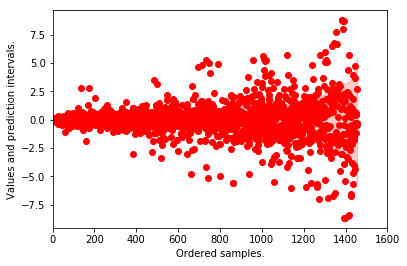

In [17]:
plt.plot(y_true_all, "ro")
plt.fill_between(
    np.arange(len(upper)), lower, upper, alpha=0.2, color="r",
    label="Pred. interval")
plt.xlabel("Ordered samples.")
plt.ylabel("Values and prediction intervals.")
plt.xlim([0, 1600])
plt.show()

In [14]:
lower.max()

-0.09555154838030026